# Station-keeping Sequence

In [1]:
import plotly.express as px
import pandas as pd
import numpy as np

from ostk.core.filesystem import Directory

from ostk.mathematics.curve_fitting import Interpolator
from ostk.mathematics.geometry.d3.object import Cuboid
from ostk.mathematics.geometry.d3.object import Composite
from ostk.mathematics.geometry.d3.object import Point

from ostk.physics import Environment
from ostk.physics.coordinate import Frame
from ostk.physics.environment.atmospheric import Earth as EarthAtmosphericModel
from ostk.physics.environment.gravitational import Earth as EarthGravitationalModel
from ostk.physics.environment.magnetic import Earth as EarthMagneticModel
from ostk.physics.environment.object.celestial import Earth
from ostk.physics.time import DateTime
from ostk.physics.time import Duration
from ostk.physics.time import Instant
from ostk.physics.time import Scale
from ostk.physics.time import Time
from ostk.physics.time import Interval
from ostk.physics.unit import Length
from ostk.physics.unit import Mass

from ostk.astrodynamics import Dynamics
from ostk.astrodynamics.dynamics import Thruster
from ostk.astrodynamics.trajectory.state import NumericalSolver
from ostk.astrodynamics.event_condition import RealCondition
from ostk.astrodynamics.trajectory.orbit.model.brouwerLyddaneMean import (
    BrouwerLyddaneMeanShort,
)
from ostk.astrodynamics.trajectory import StateBuilder
from ostk.astrodynamics.trajectory import Orbit
from ostk.astrodynamics.trajectory import Sequence
from ostk.astrodynamics.trajectory.state import CoordinateSubset
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianPosition
from ostk.astrodynamics.trajectory.state.coordinate_subset import CartesianVelocity
from ostk.astrodynamics.trajectory.orbit.model import Tabulated
from ostk.astrodynamics.flight.system import SatelliteSystem
from ostk.astrodynamics.flight.system import PropulsionSystem
from ostk.astrodynamics.guidance_law import ConstantThrust

## User inputs

Setup environment

In [2]:
earth = Earth.from_models(
    EarthGravitationalModel(
        EarthGravitationalModel.Type.EGM96, Directory.undefined(), 20, 20
    ),
    EarthMagneticModel(EarthMagneticModel.Type.Undefined),
    EarthAtmosphericModel(EarthAtmosphericModel.Type.Exponential),
)

environment = Environment(Instant.J2000(), [earth])

Initial state

In [3]:
instant = Instant.date_time(DateTime(2023, 1, 1), Scale.UTC)
initial_state = Orbit.sun_synchronous(
    instant, Length.kilometers(505.0), Time.midnight(), Earth.default()
).get_state_at(instant)

In [4]:
dry_mass = Mass.kilograms(100.0)
wet_mass = Mass.kilograms(110.0)

propulsion_system = PropulsionSystem(
    thrust_si_unit=1e-1, specific_impulse_si_unit=3000.0
)

## Setup Dynamics, initial state and Satellite System

In [5]:
satellite_geometry = Composite(
    Cuboid(Point(0.0, 0.0, 0.0), np.eye(3).tolist(), [1.0, 0.0, 0.0])
)

satellite_system = SatelliteSystem(
    dry_mass, satellite_geometry, np.eye(3), 500.0, 2.2, propulsion_system
)

In [6]:
state_builder = StateBuilder(
    frame=Frame.GCRF(),
    coordinate_subsets=[
        CartesianPosition.default(),
        CartesianVelocity.default(),
        CoordinateSubset.mass(),
        CoordinateSubset.surface_area(),
        CoordinateSubset.drag_coefficient(),
    ],
)

coordinates = [
    *initial_state.get_coordinates().tolist(),
    wet_mass.in_kilograms(),
    satellite_system.get_cross_sectional_surface_area(),
    satellite_system.get_drag_coefficient(),
]

state = state_builder.build(initial_state.get_instant(), coordinates)

In [7]:
dynamics = Dynamics.from_environment(environment)
numerical_solver = NumericalSolver.default_conditional()

### Sequence

In [8]:
sequence = Sequence(
    numerical_solver=numerical_solver,
    dynamics=dynamics,
    maximum_propagation_duration=Duration.days(30.0),
    verbosity=5,
)

evaluator = (
    lambda state: BrouwerLyddaneMeanShort.cartesian(
        (state.get_position(), state.get_velocity()),
        EarthGravitationalModel.EGM2008.gravitational_parameter,
    )
    .get_semi_major_axis()
    .in_meters()
)

# coast till under 495.0
coast_condition = RealCondition(
    name="Mean SMA crossing - coast",
    criterion=RealCondition.Criterion.StrictlyNegative,
    evaluator=evaluator,
    target_value=EarthGravitationalModel.EGM2008.equatorial_radius.in_meters()
    + 495.0e3,
)
sequence.add_coast_segment(coast_condition)

# burn till at 500.0
thrust_condition = RealCondition(
    name="Mean SMA crossing - thrust",
    criterion=RealCondition.Criterion.StrictlyPositive,
    evaluator=evaluator,
    target_value=EarthGravitationalModel.EGM2008.equatorial_radius.in_meters()
    + 500.0e3,
)
sequence.add_maneuver_segment(
    event_condition=thrust_condition,
    thruster_dynamics=Thruster(satellite_system, ConstantThrust.intrack()),
)

In [9]:
sol = sequence.solve(state, 2)
states = sol.get_states()

[2023-11-30 23:53:27.304217] [0x00007f26a8ac8740] [debug]   Solving Segment:
-- Segment -----------------------------------------------------------------------------------------
    Name:                                    Coast                                    
    Type:                                    Coast                                    
    Event Condition - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    Name:                                    Mean SMA crossing - coast                
    Target:                                  6.87314e+06                              
    Target Type:                             Absolute                                 
    Criterion:                               Strictly Negative                        
    
    Dynamics - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
    Name:                                    Central Body Gravity [Earth]             
    Nam

In [10]:
model = Tabulated(states, 0, Interpolator.Type.BarycentricRational)

In [11]:
orbit = Orbit(model, environment.access_celestial_object_with_name("Earth"))

In [12]:
interval = Interval.closed(states[0].get_instant(), states[-1].get_instant())
interpolated_states = orbit.get_states_at(
    interval.generate_grid(Duration.seconds(20.0))
)

In [13]:
data = []
for state in interpolated_states:
    blmshort = BrouwerLyddaneMeanShort.cartesian(
        (state.get_position(), state.get_velocity()),
        earth.get_gravitational_parameter(),
    )
    data.append(
        {
            "altitude": float(
                blmshort.get_semi_major_axis().in_kilometers()
                - earth.get_equatorial_radius().in_kilometers()
            ),
            "mass": float(state.get_coordinates()[6]),
            "time": state.get_instant().get_date_time(Scale.UTC),
        }
    )

In [14]:
df = pd.DataFrame(data)

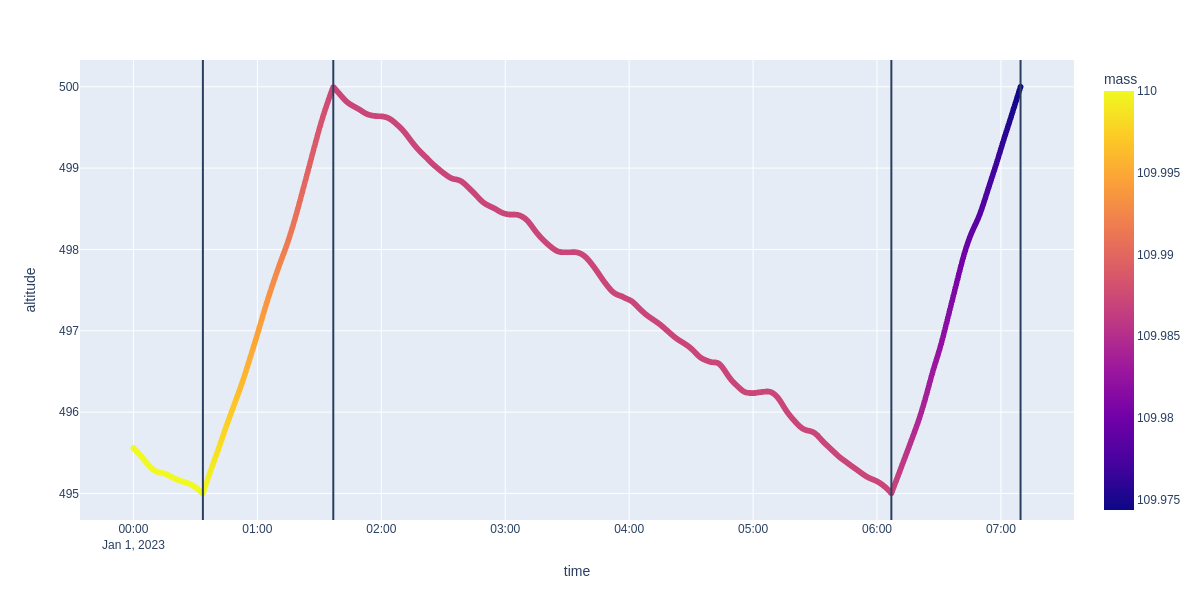

In [15]:
figure = px.scatter(
    df,
    x="time",
    y="altitude",
    color="mass",
    height=600,
    width=1200,
)
for segment_solution in sol.segment_solutions:
    time = segment_solution.states[-1].get_instant().get_date_time(Scale.UTC)
    figure.add_vline(x=time.isoformat())
figure.show("png")

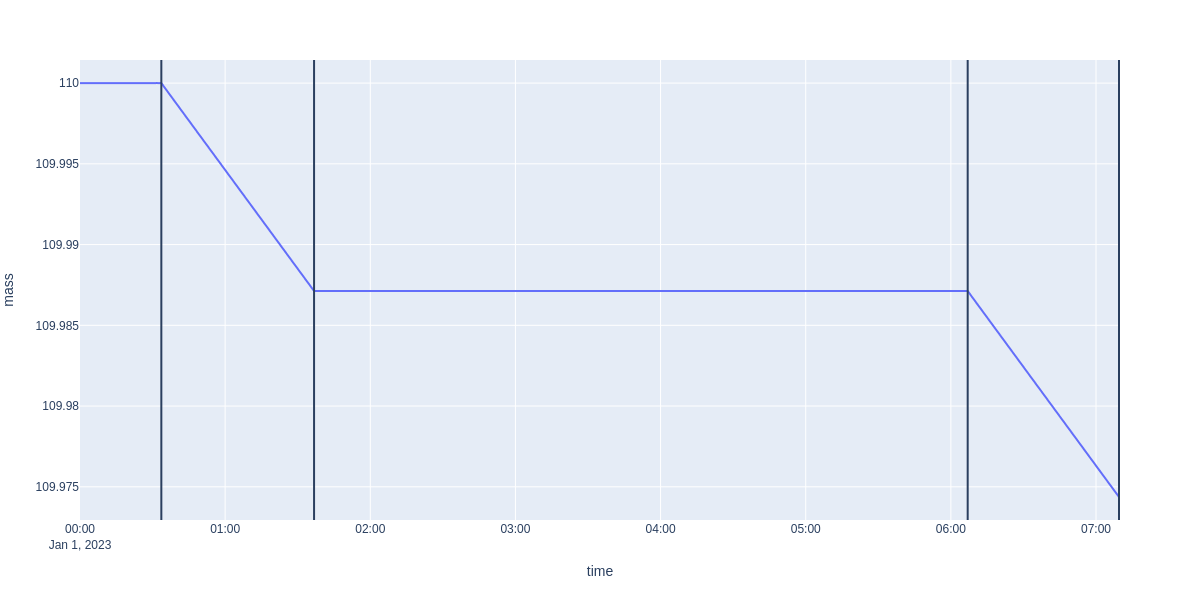

In [16]:
figure2 = px.line(
    df,
    x="time",
    y="mass",
    height=600,
    width=1200,
)
for segment_solution in sol.segment_solutions:
    time = segment_solution.states[-1].get_instant().get_date_time(Scale.UTC)
    figure2.add_vline(x=time.isoformat())
figure2.show("png")

---